[DASHBOARD PARA EQUIPO / JUGADOR](https://medium.com/geekculture/an-introduction-to-football-player-dashboards-using-python-and-matplotlib-eb5328dfe85f)

In [ ]:
import requests
from bs4 import BeautifulSoup as soup
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from PIL import Image

In [ ]:
# HAALAND'S PLAYER ID IN UNDERSTAT IS 8260
url ='https://understat.com/player/8260'
html = requests.get(url)
parse_soup = soup(html.content,'lxml')
scripts = parse_soup.find_all('script')
strings = scripts[3].string
ind_start = strings.index("('")+2
ind_end = strings.index("')")
json_data = strings[ind_start:ind_end]
json_data = json_data.encode('utf8').decode('unicode_escape')
data = json.loads(json_data)
x = []
y = []
xg = []
result = []
season = []
for i,_ in enumerate(data):
    for key in data[i]:
        if key=='X':
            x.append(data[i][key])
        if key=='Y':
            y.append(data[i][key])
        if key=='xG':
            xg.append(data[i][key])
        if key=='result':
            result.append(data[i][key])
        if key=='season':
            season.append(data[i][key])
columns = ['X','Y','xG','Result','Season']
df_understat = pd.DataFrame([x, y, xg, result, season], index=columns)
df_understat = df_understat.T
df_understat = df_understat.apply(pd.to_numeric,errors='ignore')

In [ ]:
df_understat['X'] = df_understat['X'].apply(lambda x:x*100)
df_understat['Y'] = df_understat['Y'].apply(lambda x:x*100)

In [ ]:
df_understat

,X,Y,xG,Result,Season
0,88.800003,66.599998,0.079333,Goal,2019
1,98.000000,48.900002,0.920621,Goal,2019
2,88.300003,34.700001,0.322831,Goal,2019
3,88.599998,63.900002,0.119181,BlockedShot,2019
4,95.500000,49.500000,0.746641,Goal,2019
...,...,...,...,...,...
265,98.599998,66.000000,0.306006,MissedShots,2022
266,92.500000,51.000000,0.532768,Goal,2022
267,87.400002,38.500000,0.086662,MissedShots,2022
268,77.500000,48.299999,0.033770,MissedShots,2022


In [ ]:
def readfromhtml(filepath):
    df = pd.read_html(filepath)[0]
    column_lst = list(df.columns)
    for index in range(len(column_lst)):
        column_lst[index] = column_lst[index][1]
    df.columns = column_lst
    df.drop(df[df['Player'] == 'Player'].index, inplace=True)
    df = df.fillna('0')
    df.set_index('Rk', drop=True, inplace=True)
    try:
        df['Comp'] = df['Comp'].apply(lambda x: ' '.join(x.split()[1:]))
        df['Nation'] = df['Nation'].astype(str)
        df['Nation'] = df['Nation'].apply(lambda x: x.split()[-1])
    except:
        print('Error in uploading file:' + filepath)
    finally:
        df = df.apply(pd.to_numeric, errors='ignore')
        return df
df_fbref = readfromhtml('https://fbref.com/en/comps/Big5/shooting/players/Big-5-European-Leagues-Stats')

In [ ]:
!pip install mplsoccer
!pip install highlight-text
from highlight_text import ax_text,fig_text
import mplsoccer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 KB 3.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
background = '#D6DBD9'
text_color = 'black'
mpl.rcParams['xtick.color']=text_color
mpl.rcParams['ytick.color']=text_color
mpl.rcParams['text.color']=text_color
mpl.rcParams['font.family']='Candara'
mpl.rcParams['legend.fontsize'] = 15

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
# Coge la foto que se ha subido
logo = "bvb.png"
escudo = Image.open(logo)
logo_haaland = "haaland.png"
haaland = Image.open(logo_haaland)

Mounted at /content/drive/


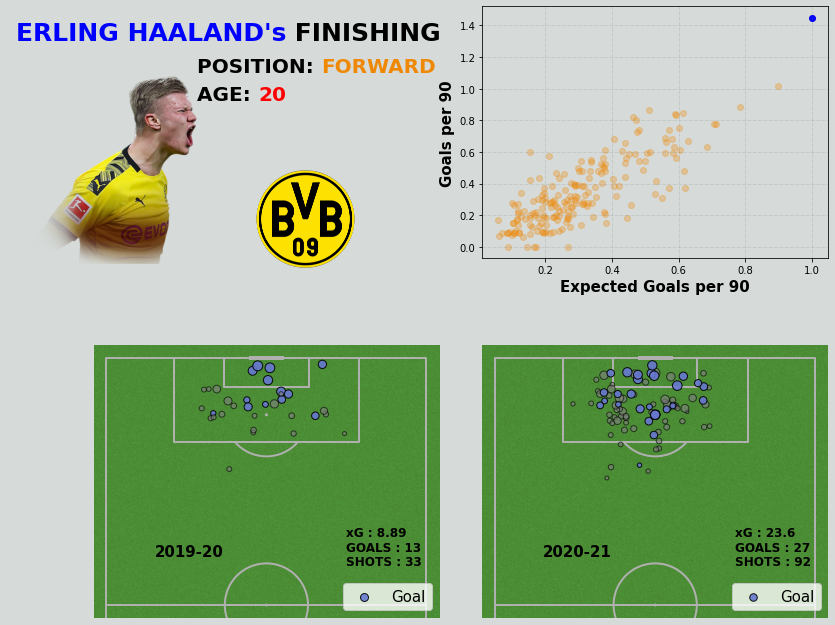

In [ ]:
# SETTING UP THE AXES
fig, ax = plt.subplots(figsize=(12,10))
ax.axis('off')
fig.set_facecolor(background)

#SETTING UP THE MPL AXIS FOR THE FIRST SEASON
pitch = mplsoccer.VerticalPitch(half=True,pitch_type='opta', pitch_color='grass')
ax_opta1 = fig.add_axes((0.1, 0.06, 0.4, 0.4))
ax_opta1.patch.set_facecolor(background)
pitch.draw(ax=ax_opta1)

#NOW PLOTTING THE GOALS IN THE 2019-20 SEASON
df_fil = df_understat.loc[df_understat['Season']==2019]
pitch.scatter(df_fil[df_fil['Result']=='Goal']['X'],df_fil[df_fil['Result']=='Goal']['Y'], 
              s=np.sqrt(df_fil[df_fil['Result']=='Goal']['xG'])*100, marker='o', alpha=0.9,
              edgecolor='black', facecolor='#6778d0', ax=ax_opta1, label='Goal')

#PLOTTING OTHER SHOTS
pitch.scatter(df_fil[df_fil['Result']!='Goal']['X'],df_fil[df_fil['Result']!='Goal']['Y'], 
              s=np.sqrt(df_fil[df_fil['Result']!='Goal']['xG'])*100, marker='o', alpha=0.6,
              edgecolor='black', facecolor='grey', ax=ax_opta1)

# ADDING THE LEGEND
ax_opta1.legend(loc='lower right').get_texts()[0].set_color("black")

ax_opta1.text(25,61,'GOALS : '+str(len(df_fil[df_fil['Result']=='Goal'])), weight='bold', size=12)
ax_opta1.text(25,64,f"xG : {round(sum(df_fil['xG']),2)}", weight='bold', size=12)
ax_opta1.text(25,58,'SHOTS : '+str(len(df_fil)), weight='bold', size=12)
ax_opta1.text(85, 60, '2019-20', weight='bold', size=15)


# DOING THE SAME FOR THE 20-21 SEASON TOO
ax_opta2 = fig.add_axes((0.55, 0.06, 0.4, 0.4))
ax_opta2.patch.set_facecolor(background)
pitch.draw(ax=ax_opta2)
#PLOTTING OTHER SHOTS
df_fil = df_understat.loc[df_understat['Season']==2020]
pitch.scatter(df_fil[df_fil['Result']!='Goal']['X'],df_fil[df_fil['Result']!='Goal']['Y'], 
              s=np.sqrt(df_fil[df_fil['Result']!='Goal']['xG'])*100, marker='o', alpha=0.6,
              edgecolor='black', facecolor='grey', ax=ax_opta2)
#NOW PLOTTING THE GOALS IN THE 2019-20 SEASON
pitch.scatter(df_fil[df_fil['Result']=='Goal']['X'],df_fil[df_fil['Result']=='Goal']['Y'], 
              s=np.sqrt(df_fil[df_fil['Result']=='Goal']['xG'])*100, marker='o', alpha=0.9,
              edgecolor='black', facecolor='#6778d0', ax=ax_opta2, label='Goal')
# ADDING THE LEGEND
ax_opta2.legend(loc='lower right').get_texts()[0].set_color("black")
ax_opta2.text(25,61,'GOALS : '+str(len(df_fil[df_fil['Result']=='Goal'])), weight='bold', size=12)
ax_opta2.text(25,64,f"xG : {round(sum(df_fil['xG']),2)}", weight='bold', size=12)
ax_opta2.text(25,58,'SHOTS : '+str(len(df_fil)), weight='bold', size=12)
ax_opta2.text(85, 60, '2020-21', weight='bold', size=15)

# NOW PLOTTING THE SCATTERPLOT
ax_scatter = fig.add_axes([0.55,0.57,0.4,0.35])
ax_scatter.patch.set_facecolor(background)


# SETTING UP THE X AND Y OF THE SCATTERPLOT
no_90s = 10
df_fil = df_fbref[df_fbref['90s']>=no_90s]
df_fil = df_fil[df_fil['Pos'].apply(lambda x: x in ['FW','MF,FW','FW,MF'])]
x,y = (df_fil['xG']/df_fil['90s']).to_list(), (df_fil['Gls']/df_fil['90s']).to_list()
ax_scatter.scatter(x,y,alpha=0.3,c='#EF8804')

# NOW FILTERING ERLING HAALAND'S DATA
df_player = df_fil[df_fil['Player']=='Erling Haaland']
ax_scatter.scatter(df_player['xG']/df_player['90s'], df_player['Gls']/df_player['90s'], c='blue')

# ADDING FINISHING TOUCHES TO THE SCATTERPLOT
ax_scatter.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.4)
ax_scatter.set_xlabel('Expected Goals per 90', fontdict = {'fontsize':15, 'weight' : 'bold', 'color':text_color})
ax_scatter.set_ylabel('Goals per 90', fontdict = dict(fontsize = 15, weight = 'bold',color=text_color))

#ADDING HAALAND'S IMAGE
ax_player = fig.add_axes([0,0.43,0.25,0.45])
ax_player.axis('off')
#im = plt.imread('haaland.png')
ax_player.imshow(haaland)

# ADDING TITLES AND INFO
fig_text(0.01,0.90,"<ERLING HAALAND's> FINISHING",weight='heavy', size=25, highlight_textprops=[{'color':'blue'}])
fig_text(0.22,0.85,'POSITION: <FORWARD>',weight='bold', size=20, highlight_textprops=[{'color':'#EF8804'}])
fig_text(0.22,0.81,'AGE: <20>',weight='bold', size=20, highlight_textprops=[{'color':'red'}])

# ADDING CLUB LOGO
ax_team = fig.add_axes([0.27,0.55,0.15,0.15])
ax_team.axis('off')
#im = plt.imread('bvb.png')
ax_team.imshow(escudo)

# ADDING A FOOTER
fig_text(0.05,0.03,'Made by Shreyas Khatri/@khatri_shreyas. Data from Fbref.com and Understat.com. Comparison with <forwards>'+
        ' with more than '+str(no_90s)+' 90s('+str(no_90s*90)+' minutes).',
        size=12, highlight_textprops=[{'color':'#EF8804'}], weight = 'bold')